In [1]:
using PyCall
using XGPaint
using Healpix
hp = pyimport("healpy")
using PyPlot
using Unitful, UnitfulAstro
import PhysicalConstants.CODATA2018: BoltzmannConstant, PlanckConstant, SpeedOfLightInVacuum
using HDF5


freq = 143.0
int_freq = Int(freq)

flux_143 = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(143.0).h5", "flux");
flux = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq).h5", "flux")
θ = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq).h5", "theta")
ϕ = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq).h5", "phi");

const TCMB = 2.725u"K"
xf(ν) = float(PlanckConstant) * ν / float(BoltzmannConstant) / TCMB
MJy_mul(ν) = 1.05e3 * expm1(xf(ν))^2 * exp(-xf(ν)) * (ν/100u"GHz")^(-4)
tSZ_mul(ν) = 1e6u"1/K" * TCMB * (xf(ν) * (exp(xf(ν))+1) / expm1(xf(ν)) - 4)

┌ Info: Precompiling XGPaint [af630e4a-6754-4ec2-ab8a-f9f8b9ebafbf]
└ @ Base loading.jl:1278
┌ Info: Precompiling PhysicalConstants [5ad8b20f-a522-5ce9-bfc9-ddf1d5bda6ab]
└ @ Base loading.jl:1278


tSZ_mul (generic function with 1 method)

In [7]:
nside = 4096
m_radio = Map{Float64,RingOrder}(nside)
flux_cut = 7e-3
cut_array = flux_143 .< flux_cut  # in Jy
XGPaint.catalog2map!(m_radio, flux[cut_array], θ[cut_array], ϕ[cut_array])

MJy_factor = MJy_mul(freq * 1u"GHz")
m_radio .*= MJy_factor / 1e6;  # CONVERT TO muK, note that our maps are in Jy/sr

mask =  Map{Float64,RingOrder}(nside)
# mask_array = .!(cut_array)
# XGPaint.catalog2map!(mask, flux[mask_array], θ[mask_array], ϕ[mask_array]);
# mask.pixels[mask.pixels .> 0.0] .= 1.0
# mask.pixels .= 1.0 .- mask.pixels;

In [20]:
using ProgressMeter

function scoop!(m, θsource, ϕsource, scoop_radius)
    nsources = length(θsource)
    @showprogress for i in 1:nsources
        disc = hp.query_disc(nside, ang2vec(θsource[i], ϕsource[i]), scoop_radius) .+ 1
        m.pixels[disc] .= 0.0
    end
end

scoop! (generic function with 1 method)

In [45]:
max_disc_in_arcmin = 8
max_disc = deg2rad(max_disc_in_arcmin / 60)

mask =  Map{Float64,RingOrder}(nside)
mask.pixels .= 1.0
mask_array = .!(cut_array)

SOURCE_SCOOP_ARCMIN = 5.0
scoop!(mask, θ[mask_array], ϕ[mask_array], deg2rad(SOURCE_SCOOP_ARCMIN / 60))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


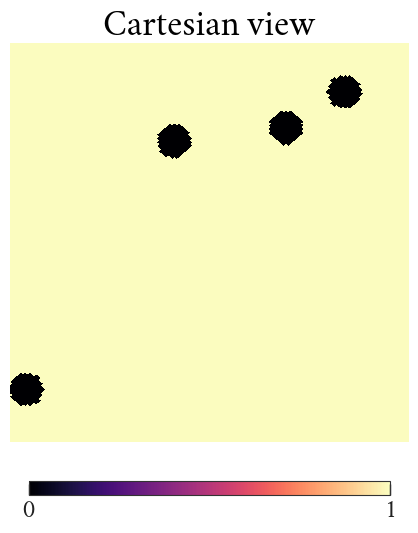

In [46]:
hp.cartview(mask.pixels, lonra=[-1,1], latra=[-1,1])

In [47]:
nmt = pyimport("pymaster")
aposcale = 10 / 60
mask.pixels = nmt.mask_apodization(mask.pixels, aposcale, apotype="C2");

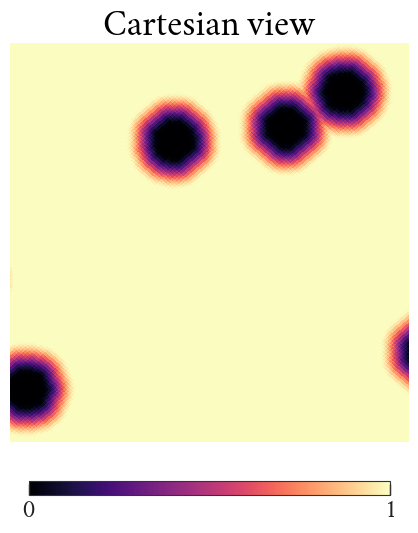

In [48]:
hp.cartview(mask.pixels, lonra=[-1,1], latra=[-1,1])

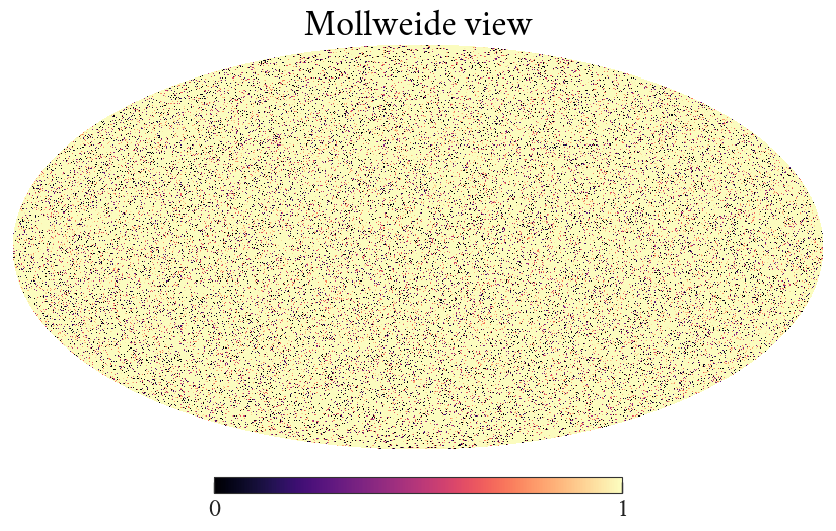

In [50]:
hp.mollview(mask.pixels)
hp.write_map("/tigress/zequnl/websky/radiomask_143_7mJy.fits", mask.pixels)